In [35]:
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

In [36]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

In [37]:
features = load_object('../../data/train', 'ring')
features = torch.from_numpy(features)

In [38]:
features

tensor([[ 4.8302,  1.7729],
        [-3.0147,  3.6299],
        [-2.7704, -4.4909],
        ...,
        [ 4.9549, -0.0193],
        [-3.0155, -3.9369],
        [ 5.2306,  0.5260]], dtype=torch.float64)

In [39]:
C = 1000
D = 2

means = torch.zeros(C, D, dtype=torch.float64).normal_(0, 2)

mu0 = means[0]
mu1 = means[1]

In [40]:
L = torch.normal(2, 0.5, size=(C, 1, 1)) * torch.eye(D, D).view(1, D, D)
#L = torch.normal(2, 0.5, size=(C, 2, 2)) 
sigmas = (L).type(torch.float64).contiguous()
print(sigmas[0])
print(torch.tril(sigmas[0]))
S0 = torch.tril(sigmas[0]) @ torch.tril(sigmas[0]).t()
S1 = torch.tril(sigmas[1]) @ torch.tril(sigmas[1]).t()

print(mu0, mu1, S0, S1)

tensor([[1.7996, 0.0000],
        [0.0000, 1.7996]], dtype=torch.float64)
tensor([[1.7996, 0.0000],
        [0.0000, 1.7996]], dtype=torch.float64)
tensor([-2.0815, -0.9598], dtype=torch.float64) tensor([-0.6911,  2.4977], dtype=torch.float64) tensor([[3.2386, 0.0000],
        [0.0000, 3.2386]], dtype=torch.float64) tensor([[4.7131, 0.0000],
        [0.0000, 4.7131]], dtype=torch.float64)


In [41]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(torch.inverse(Si) + torch.inverse(Sj))
        mu = sigma @ (torch.inverse(Si) @ mui + torch.inverse(Si) @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    Sj = torch.tril(sigmas[j]) @ torch.tril(sigmas[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, means[i], means[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())

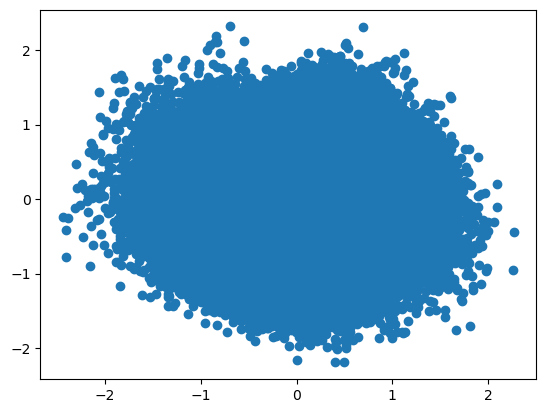

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.array(recomputed_params['means'])[:,0], np.array(recomputed_params['means'])[:,1])
plt.show()

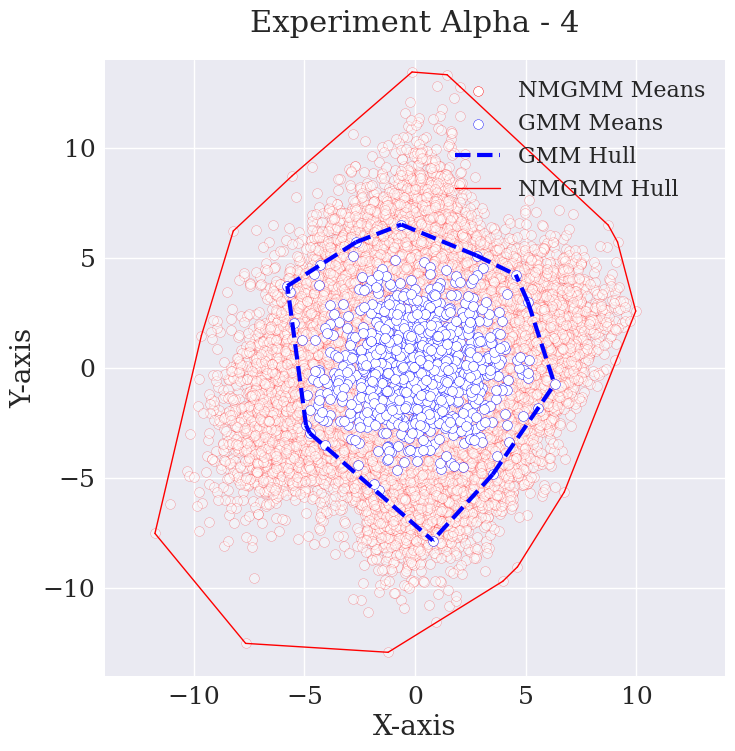

<Figure size 800x550 with 0 Axes>

In [45]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

plt.style.use('seaborn')


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 20,
    "font.size": 20,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 16,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16
}

plt.rcParams.update(tex_fonts)


hull1 = ConvexHull(means)
hull2 = ConvexHull(np.array(recomputed_params['means']))

fig, ax = plt.subplots(figsize=(8,8))

ax.set_title(r'Experiment Alpha - 4', fontsize=22, pad=20)
ax.set_xlabel(r'X-axis')
ax.set_ylabel(r'Y-axis')

ax.set_xlim(-14, 14)
ax.set_ylim(-14, 14)

nmgmm_points = ax.scatter(
                np.array(recomputed_params['means'])[:,0],
                np.array(recomputed_params['means'])[:,1], 
                color='white',
                edgecolors='r',
                alpha=0.4,
                label='NMGMM Means')

gmm_points = ax.scatter(
                means[:,0], 
                means[:,1],
                color='white',
                edgecolors='blue',
                label='GMM Means')

for simplex in hull1.simplices:
    gmm_hull = ax.plot(
        means[simplex, 0],
        means[simplex, 1],
        'b--',
        linewidth=3,
        label='GMM Hull'
    )

for simplex in hull2.simplices:
    nmgmm_hull = ax.plot(
        np.array(recomputed_params['means'])[simplex, 0],
        np.array(recomputed_params['means'])[simplex, 1], 
        'r-',
        linewidth=1,
        label='NMGMM Hull'
    )

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), loc=1)

for lh in legend.legendHandles: 
    lh.set_alpha(1)

plt.show()
plt.draw()
fig.savefig('convexhull_mean_translations.png')

In [133]:
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def _confidence_ellipse(ax, sigma, mu, n_std=2.3, facecolor='none', **kwargs):
        pearson = sigma[0][1]/np.sqrt(sigma[0][0] * sigma[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(sigma[0][0]) * n_std
        mean_x = mu[0]

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(sigma[1][1]) * n_std
        mean_y = mu[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def plot_contours(means, sigmas):
        _, ax = plt.subplots()

        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)

        for i in range(C):
            sigma = sigmas[i]
            mu = means[i]
            
            config = {
                'alpha': .2
            }

            _confidence_ellipse(ax, sigma, mu, **config)
            ax.scatter(mu[0], mu[1], c='red', s=3)
        
        plt.plot()

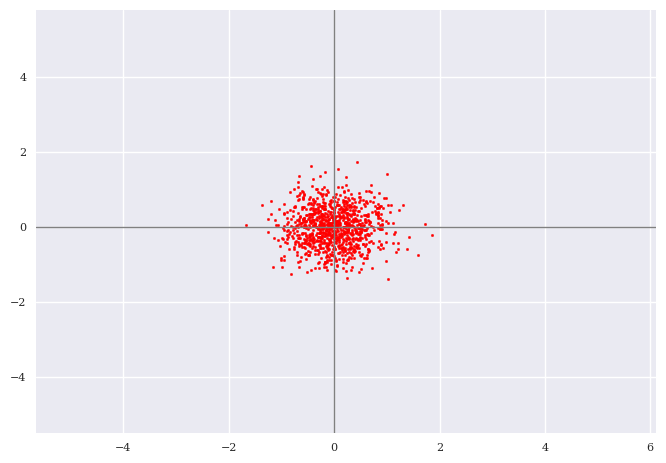

In [121]:
plot_contours(means.data.cpu().numpy(), sigmas.data.cpu().numpy())

In [42]:
sqrd_gen_variance = []

for i in range(C):
    S = recomputed_params['sigmas'][i]
    sqrd_gen_variance.append(np.linalg.det(S))

sqrd_gen_variance = np.array(sqrd_gen_variance)
sqrd_gen_variance

array([2.62214513e+00, 3.68474690e+00, 4.67904351e+00, 5.38752751e+00,
       2.18652283e+00, 2.53096151e+00, 2.77506414e+00, 2.85376878e+00,
       2.63255674e+00, 3.87104930e+00, 3.89808140e+00, 1.24588449e+00,
       5.82418136e+00, 3.97323762e+00, 2.10848885e+00, 3.83858429e+00,
       1.65257349e+00, 3.20237179e+00, 4.03382361e+00, 3.62033818e+00,
       3.54314023e+00, 2.86740530e+00, 4.54589310e+00, 1.58920937e+00,
       4.70738333e+00, 2.14030218e+00, 4.22771662e+00, 5.54778868e+00,
       3.74300497e+00, 2.64901958e+00, 4.00622304e+00, 1.49111653e+00,
       4.33515809e+00, 3.31993264e+00, 3.65444685e+00, 3.63321162e+00,
       3.36063451e+00, 3.50507458e+00, 2.95327145e+00, 3.49365077e+00,
       5.07482053e+00, 1.97663029e+00, 1.22957561e+00, 9.84555223e-03,
       3.28908666e+00, 6.79676538e-01, 2.70920977e+00, 9.56383399e-01,
       1.22377515e+00, 2.45610843e+00, 2.27565516e+00, 8.63528767e-01,
       2.06498707e+00, 1.98757779e+00, 3.60207306e+00, 1.90047335e+00,
      

In [43]:
gen_variance = []

for i in range(C):
    S = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    S = S.data.cpu().numpy()
    
    gen_variance.append(np.linalg.det(S))

gen_variance = np.array(gen_variance)
gen_variance

array([1.04885805e+01, 2.22131186e+01, 4.24281885e+01, 6.71260712e+01,
       7.40432969e+00, 9.77781113e+00, 1.17670434e+01, 1.24699804e+01,
       1.05721220e+01, 2.51292450e+01, 2.55799929e+01, 2.90090521e+00,
       8.96923833e+01, 2.68724066e+01, 6.92883977e+00, 2.45974755e+01,
       4.54397577e+00, 1.59954839e+01, 2.79578369e+01, 2.12777154e+01,
       2.02024168e+01, 1.25950272e+01, 3.89434865e+01, 4.26048194e+00,
       4.32091348e+01, 7.12010748e+00, 3.17135468e+01, 7.45908709e+01,
       2.30904913e+01, 1.07052373e+01, 2.74584156e+01, 3.84240711e+00,
       3.39959912e+01, 1.73535593e+01, 2.17686341e+01, 2.14618390e+01,
       1.78457722e+01, 1.96898959e+01, 1.34052883e+01, 1.95383038e+01,
       5.47641961e+01, 6.17260413e+00, 2.84325976e+00, 1.04777535e-02,
       1.69882150e+01, 1.22314708e+00, 1.12027352e+01, 1.96281125e+00,
       2.82290087e+00, 9.22142782e+00, 7.97426445e+00, 1.69830532e+00,
       6.67293008e+00, 6.23320991e+00, 2.10188651e+01, 5.76153260e+00,
      

<BarContainer object of 2 artists>

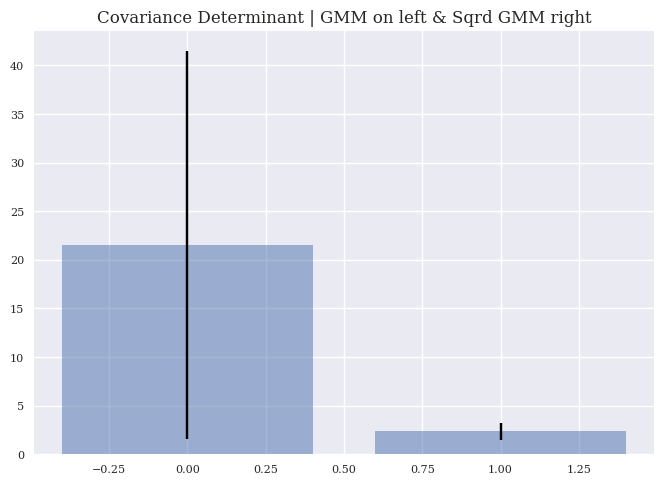

In [136]:
plt.title('Covariance Determinant | GMM on left & Sqrd GMM right')
plt.bar((0, 1), (gen_variance.mean(), sqrd_gen_variance.mean()), yerr=(gen_variance.std(), sqrd_gen_variance.std()), align='center', alpha=0.5)



In [44]:
print(sqrd_gen_variance.mean() - gen_variance.mean())

-18.45976386509063


[<matplotlib.patches.Patch object at 0x7fd9c6bc9480>, <matplotlib.patches.Patch object at 0x7fd9c6bc9480>]


<Figure size 800x550 with 0 Axes>

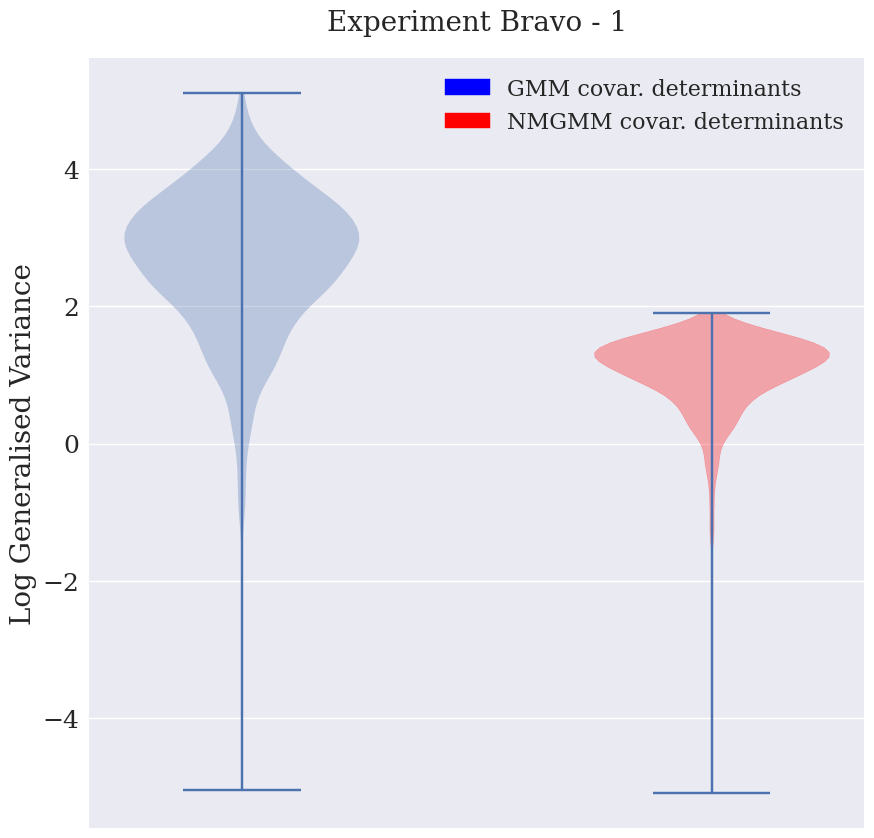

<Figure size 800x550 with 0 Axes>

In [46]:
import matplotlib.patches as mpatches
from itertools import repeat

plt.style.use('seaborn')


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 20,
    "font.size": 20,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 16,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16
}

plt.rcParams.update(tex_fonts)

fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([], [])

ax.set_title('Experiment Bravo - 1', fontsize=20, pad=20)
ax.set_ylabel('Log Generalised Variance')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([np.log(gen_variance), np.log(sqrd_gen_variance)])
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance_log.png')

In [ ]:
import matplotlib.patches as mpatches
from itertools import repeat
    
fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yticks([], [])

ax.set_title('2D Generalised Variance')
ax.set_xlabel('Generalised variance (Sigma determinant)')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([gen_variance, sqrd_gen_variance], vert=False)
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance.png')